In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

layer_height = 0.4
layer_count = 12
delta = 0.8

In [3]:
def read_data_file(filename):
    '''
    Read a data file and return a list of polygons.
    Returns:
        polygons = [polygon1, polygon2, polygon3, ...]
        polygon  = [[vertex1, vertex2, ...], [hinge1, hinge2, ...]]
        vertex   = [x, y]
        hinge    = [side_number, hinge_orientation, bending_angle]
    '''
    
    data = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()  
            if line and not line.startswith('#'):  
                numbers = [float(x) for x in line.split()]  
                data.append(numbers)
    
    polygons = []
    line = 0
    
    num_polygons = int(data[line][0])
    line += 1
    
    for i in range (num_polygons):
        num_vertices = int(data[line][0])
        num_hinges = int(data[line][1])
        line += 1
        
        vertices = []
        for j in range (num_vertices):
            vertices.append(data[line])
            line += 1
        
        hinges = []
        for j in range (num_hinges):
            hinges.append(data[line])
            line += 1
        
        polygons.append([vertices, hinges])
        
    return polygons

In [4]:
def draw_polygons(polygons):
    """
    Draw the origami pattern represented by the given polygons data.

    Args:
        polygons: from read_data_file
    """

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    for polygon in polygons:
        vertices = polygon[0]
        for x, y in vertices:
            min_x = min(min_x, x)
            min_y = min(min_y, y)
            max_x = max(max_x, x)
            max_y = max(max_y, y)

    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)

    marked_edges = set()  

    for polygon in polygons:
        vertices = polygon[0]
        highlight_edges = polygon[1]

        for i in range(len(vertices)):
            x1, y1 = vertices[i]
            x2, y2 = vertices[(i + 1) % len(vertices)]
            color = 'black'  
            edge_key = tuple(sorted(((x1, y1), (x2, y2))))  
            text_color = 'black' 

            for edge_info in highlight_edges:
                edge_index = int(edge_info[0]) - 1
                if i == edge_index:
                    color_code = int(edge_info[1])
                    if color_code == 1:
                        color = 'blue'
                    elif color_code == 0:
                        color = 'red'
                    
                    if edge_key not in marked_edges:  
                        value = edge_info[2]  

                        mid_x = (x1 + x2) / 2
                        mid_y = (y1 + y2) / 2

                        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1)) - 90
                        if angle < 0:
                            angle += 360

                        ax.text(mid_x, mid_y, str(value), color=text_color, ha='center', va='center', rotation=angle, fontweight='bold')

                        marked_edges.add(edge_key)  
                        break  
            
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

    plt.title("Origami Pattern")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

In [5]:
def calculate_b(theta):
    
    t = theta * np.pi / 180 / 2   
    d = layer_height
    h = d * 2
    a = d * (layer_count - 2)
    b = a * np.tan(t) + 1/np.cos(t) * (h - (delta/(t*2) - d/2)*np.sin(t))

    return b

def calculate_width(direction, theta):
    if theta <= 90:
        b = calculate_b(theta)
        w = 2 * b + delta
        if direction == 1:
            w *= -1
        return w
    
    else:
        theta = theta / 2
        b = calculate_b(theta)
        w = 2 * (2 * b + delta) + delta
        if direction == 1:
            w *= -1
        return w

In [6]:
def is_same_vertex(v1, v2, tolerance=0.001):
    """
    比较两个顶点是否相同。
    """
    return abs(v1[0] - v2[0]) < tolerance and abs(v1[1] - v2[1]) < tolerance

In [7]:
def polygon_array_to_graph(polygon_array):
    """
    将多边形数组转换为无环图。
    """
    graph = nx.Graph()
    polygon_count = len(polygon_array)

    # 添加节点（多边形）到图中
    for i in range(polygon_count):
        graph.add_node(i)

    # 找到连接的边并添加到图中
    for i in range(polygon_count):
        for j in range(i + 1, polygon_count):  # 避免重复和自身连接
            polygon1_vertices = polygon_array[i][0]
            polygon1_connections = polygon_array[i][1]
            polygon2_vertices = polygon_array[j][0]
            polygon2_connections = polygon_array[j][1]

            for conn1 in polygon1_connections:
                edge_index1 = int(conn1[0])
                v1_index1 = (edge_index1 - 1) % len(polygon1_vertices)
                v2_index1 = edge_index1 % len(polygon1_vertices)
                v1 = polygon1_vertices[v1_index1]
                v2 = polygon1_vertices[v2_index1]
                width1 = calculate_width(conn1[1], conn1[2])

                for conn2 in polygon2_connections:
                    edge_index2 = int(conn2[0])
                    v3_index2 = (edge_index2 - 1) % len(polygon2_vertices)
                    v4_index2 = edge_index2 % len(polygon2_vertices)
                    v3 = polygon2_vertices[v3_index2]
                    v4 = polygon2_vertices[v4_index2]
                    width2 = calculate_width(conn2[1], conn2[2])

                    # 更严格的连接判断：比较端点坐标
                    if (is_same_vertex(v1, v3) and is_same_vertex(v2, v4)) or \
                       (is_same_vertex(v1, v4) and is_same_vertex(v2, v3)):
                        graph.add_edge(i, j, weight=width1)
                        break  # 找到了连接，不再遍历
    return graph

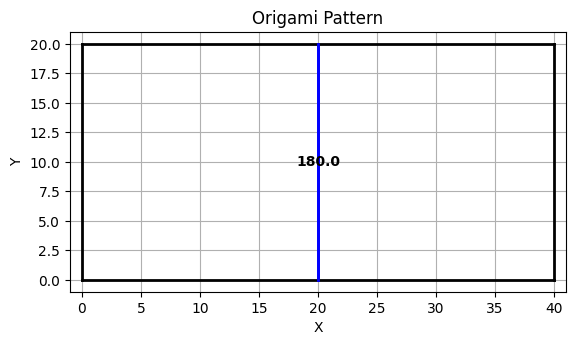

图的边: [(0, 1, {'weight': -21.688300128017644})]


In [ ]:
# filename = 'data_files/single_90.dat'
# filename = 'data_files/single_180.dat'
# filename = 'data_files/zig-zag.dat'
filename = 'data_files/cube.dat'

polygons = read_data_file(filename)
draw_polygons(polygons)



In [9]:
def has_cycles(graph):
    """
    判断图是否包含环。
    """
    try:
        nx.find_cycle(graph)
        return True
    except nx.NetworkXNoCycle:
        return False

In [10]:
has_cycles(graph)

False

In [11]:
def get_subtree_nodes(graph, root, visited=None):
    """
    获取以给定节点为根的子树中的所有节点。
    """
    if visited is None:
        visited = set()
    subtree_nodes = set()
    stack = [root]
    while stack:
        node = stack.pop()
        if node not in visited:
            subtree_nodes.add(node)
            visited.add(node)
            for neighbor in graph.neighbors(node):
                if neighbor not in visited:
                    stack.append(neighbor)
    return list(subtree_nodes)

In [12]:
def edge_vector(polygon_index, neighbor_index, graph, polygon_array):
    """
    计算垂直于边的向量，方向从 polygon_index 指向 neighbor_index 所在的多边形。
    """

    polygon1_vertices = polygon_array[polygon_index][0]
    polygon2_vertices = polygon_array[neighbor_index][0]
    #寻找公共边
    v1,v2 = None, None
    for conn1 in polygon_array[polygon_index][1]:
        edge_index1 = int(conn1[0])
        v1_index1 = (edge_index1 - 1) % len(polygon1_vertices)
        v2_index1 = edge_index1 % len(polygon1_vertices)
        candidate_v1 = polygon1_vertices[v1_index1]
        candidate_v2 = polygon1_vertices[v2_index1]
        for conn2 in polygon_array[neighbor_index][1]:
            edge_index2 = int(conn2[0])
            neighbor_v1_index2 = (edge_index2 - 1) % len(polygon2_vertices)
            neighbor_v2_index2 = edge_index2 % len(polygon2_vertices)
            neighbor_v1 = polygon2_vertices[neighbor_v1_index2]
            neighbor_v2 = polygon2_vertices[neighbor_v2_index2]

            # 匹配端点
            if (is_same_vertex(candidate_v1, neighbor_v1) and is_same_vertex(candidate_v2, neighbor_v2)) or \
                    (is_same_vertex(candidate_v1, neighbor_v2) and is_same_vertex(candidate_v2, neighbor_v1)):
                v1,v2 = candidate_v1, candidate_v2
                break

    if v1 is None or v2 is None:
        return np.array([0.0, 0.0])

    # 计算边的方向向量
    edge_direction = np.array(v2) - np.array(v1)
    # 垂直向量 (交换 x 和 y，然后取反一个)
    normal_vector = np.array([-edge_direction[1], edge_direction[0]])
    # 归一化向量
    norm = np.linalg.norm(normal_vector)
    if norm == 0:
        return np.array([0.0, 0.0])  # 避免除以零
    normalized_vector = normal_vector / norm

    weight = graph[polygon_index][neighbor_index]['weight']
    # 乘以权重的绝对值来确定向量的大小
    return normalized_vector * abs(weight)


In [13]:
def dfs_tree_traversal(graph, root, polygon_array, visited=None, result=None):
    """
    使用深度优先搜索遍历树，并将结果存储在高维列表中。
    """
    if visited is None:
        visited = set()
    if result is None:
        result = []

    visited.add(root)

    for neighbor in graph.neighbors(root):
        if neighbor not in visited:
            edge_data = graph.get_edge_data(root, neighbor)
            weight = edge_data['weight']

            # 计算向量
            vector = edge_vector(root, neighbor, graph, polygon_array)

            subtree_nodes = get_subtree_nodes(graph, neighbor, visited.copy())
            result.append([[root, neighbor], weight, subtree_nodes, vector.tolist()])  # 存储结果，并将 NumPy 数组转换为列表

            dfs_tree_traversal(graph, neighbor, polygon_array, visited, result)  # 递归调用

    return result

In [14]:
edges = dfs_tree_traversal(graph, 0, polygons)

In [15]:
def transform_polygons(polygon_array, edges):
    """
    对子树中的多边形顶点进行平移。

    Args:
        polygon_array: 原始多边形数组。
        edges:  dfs_tree_traversal 函数的输出结果 (edges 列表)。

    Returns:
        修改后的多边形数组。
    """
    transformed_polygon_array = [
        [np.array(vertices).tolist(), connections] for vertices, connections in polygon_array
    ]

    for edge in edges:
        _, _, subtree_nodes, translation_vector = edge
        translation_vector = np.array(translation_vector)  # 将平移向量转换为 NumPy 数组

        for node_index in subtree_nodes:
            # 将对应多边形的顶点坐标都加上平移向量
            transformed_polygon_array[node_index][0] = (np.array(transformed_polygon_array[node_index][0]) - translation_vector).tolist() #转换为list

    return transformed_polygon_array

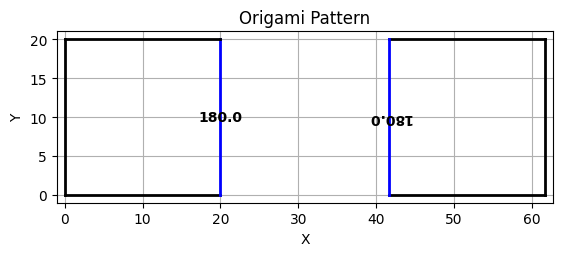

In [16]:
polygons_modified = transform_polygons(polygons, edges)
    
draw_polygons(polygons_modified)

In [17]:
def remove_duplicate_polygons(polygon_array, tolerance=1e-6):
    """
    从多边形数组中删除重复的多边形（考虑顶点顺序不同的情况）。

    Args:
        polygon_array: 原始多边形数组。
        tolerance: 比较浮点数时使用的容差值。

    Returns:
        一个包含唯一多边形的新多边形数组。
    """

    unique_polygons = []
    seen = set()

    for polygon in polygon_array:
        # 获取顶点坐标
        vertices = polygon[0]
        # 转换为 NumPy 数组，方便后续操作
        np_vertices = np.array(vertices)
        # 对顶点坐标进行排序 (按字典序排列)
        sorted_vertices = np_vertices[np.lexsort(np.transpose(np_vertices))]
        # 将排序后的顶点坐标转换为元组的元组，使其可哈希
        hashable_vertices = tuple(tuple(v) for v in sorted_vertices)

        # 判断是否已经见过这个多边形
        if hashable_vertices not in seen:
            is_duplicate = False
            for seen_polygon in unique_polygons:
                seen_np_vertices = np.array(seen_polygon[0])
                # 对已见过的多边形的顶点进行排序
                seen_sorted_vertices = seen_np_vertices[np.lexsort(np.transpose(seen_np_vertices))]
                # 比较排序后的顶点是否相同
                if np.allclose(sorted_vertices, seen_sorted_vertices, atol=tolerance):
                    is_duplicate = True
                    break

            if not is_duplicate:
                unique_polygons.append(polygon)
                seen.add(hashable_vertices) #存储hashable_vertices

    return unique_polygons

In [18]:
def translate_connected_edges(polygon_array):
    """
    将每个多边形与别的多边形相连的边进行处理，插入新顶点并更新连接信息。

    Args:
        polygon_array: 原始多边形数组。

    Returns:
        修改后的多边形数组。
    """
    
    polygons_island = []

    transformed_polygon_array = []
    for polygon_index, (vertices, connections) in enumerate(polygon_array):
        new_vertices = vertices[:]  # 复制顶点列表，避免修改原始数据
        new_connections = []  # 创建新的连接信息列表

        insert_info = []  # 存储要插入的顶点信息 (索引，顶点坐标)
        vertex_count = len(vertices)

        # count = 0
        for conn in connections:
        # for i in range (len(connections)):
        #     conn = connections[-(i+1)]
            edge_index = int(conn[0])
            theta = conn[2]
            if theta > 90:
                theta /= 2
                
            width = np.abs(calculate_width(conn[1], theta))  # 使用绝对值
            translation_distance = (width - delta) / 2.0

            # 获取边的顶点坐标
            v1_index = (edge_index - 1) % vertex_count
            v2_index = edge_index % vertex_count
            v1 = vertices[v1_index]
            v2 = vertices[v2_index]

            # 计算新的顶点位置
            edge_direction = np.array(v2) - np.array(v1)
            normal_vector = np.array([edge_direction[1], - edge_direction[0]])

            # # 确保法向量指向多边形外部
            # center = np.mean(np.array(vertices), axis=0)
            # midpoint = (np.array(v1) + np.array(v2)) / 2.0
            # to_center = center - midpoint

            # if np.dot(normal_vector, to_center) > 0:
            #     normal_vector = -normal_vector

            # 归一化向量
            norm = np.linalg.norm(normal_vector)
            if norm == 0:
                print('Warning: Normal vector is zero. Maybe two vertices are duplicate.')
                continue  # 避免除以零
            normalized_vector = normal_vector / norm
            translation_vector = normalized_vector * translation_distance

            # 计算新的顶点位置
            new_v1 = np.array(v1) + translation_vector
            new_v2 = np.array(v2) + translation_vector

            # 存储插入信息（在 v2 之前插入 new_v1，然后在 v2 之前插入 new_v2）
            insert_info.append((v1_index, new_v1.tolist()))
            insert_info.append((v1_index, new_v2.tolist()))
            # if count == 0:
            # count += 1
            
            # add island polygons
            if conn[2] > 90:
                vi1 = v1 + normalized_vector * (translation_distance + delta)
                vi2 = v2 + normalized_vector * (translation_distance + delta)
                vi3 = v2 + normalized_vector * (np.abs(calculate_width(conn[1], conn[2])) - translation_distance - delta)
                vi4 = v1 + normalized_vector * (np.abs(calculate_width(conn[1], conn[2])) - translation_distance - delta)
                
                polygons_island.append([[vi2.tolist(), vi1.tolist(), vi4.tolist(), vi3.tolist()], [[1, conn[1], conn[2]], [3, conn[1], conn[2]]]])
                
                print('add island polygons: ', polygons_island[-1])
                
        # print(insert_info)

        # 插入新顶点
        offset = 1
        # for i, insert_vertex in sorted(insert_info):  # 确保索引从小到大排列
        for i, insert_vertex in insert_info:
            new_vertices.insert(i + offset, insert_vertex)
            offset += 1

        # 更新连接信息
        offset = 1
        for conn in connections:
            edge_index = int(conn[0])
            #由于顶点插入到边的第二个顶点，因此坐标不会发生改变
            new_connections.append([edge_index + offset, conn[1], conn[2]]) #添加未修改的连接信息
            offset += 2

        transformed_polygon_array.append([new_vertices, new_connections])
        
    print(polygons_island)

    transformed_polygon_array += remove_duplicate_polygons(polygons_island)
    
    for i in range (len(transformed_polygon_array)):
        for j in range (len(transformed_polygon_array[i][1])):
            if transformed_polygon_array[i][1][j][2] > 90:
                transformed_polygon_array[i][1][j][2] /= 2
                
    return transformed_polygon_array


add island polygons:  [[[25.62207503200441, 20.0], [25.62207503200441, 0.0], [36.066225096013234, 0.0], [36.066225096013234, 20.0]], [[1, 1.0, 180.0], [3, 1.0, 180.0]]]
add island polygons:  [[[36.066225096013234, 0.0], [36.066225096013234, 20.0], [25.62207503200441, 20.0], [25.62207503200441, 0.0]], [[1, 1.0, 180.0], [3, 1.0, 180.0]]]
[[[[25.62207503200441, 20.0], [25.62207503200441, 0.0], [36.066225096013234, 0.0], [36.066225096013234, 20.0]], [[1, 1.0, 180.0], [3, 1.0, 180.0]]], [[[36.066225096013234, 0.0], [36.066225096013234, 20.0], [25.62207503200441, 20.0], [25.62207503200441, 0.0]], [[1, 1.0, 180.0], [3, 1.0, 180.0]]]]


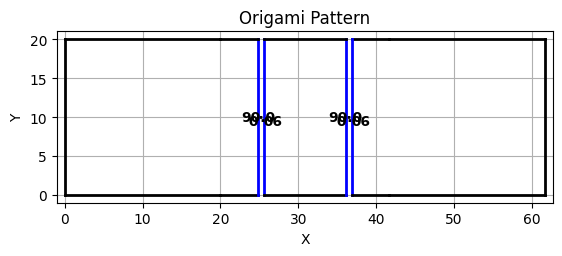

In [19]:
transformed_polygons =  translate_connected_edges(polygons_modified)
draw_polygons(transformed_polygons)

In [20]:
def translate_to_continent(polygon_array):
    """
    将每个多边形与别的多边形相连的边进行处理，插入新顶点并更新连接信息。

    Args:
        polygon_array: 原始多边形数组。

    Returns:
        修改后的多边形数组。
    """

    transformed_polygon_array = []
    for polygon_index, (vertices, connections) in enumerate(polygon_array):
        new_vertices = vertices[:]  # 复制顶点列表，避免修改原始数据
        new_connections = []  # 创建新的连接信息列表

        insert_info = []  # 存储要插入的顶点信息 (索引，顶点坐标)
        vertex_count = len(vertices)

        # count = 0
        for conn in connections:
        # for i in range (len(connections)):
        #     conn = connections[-(i+1)]
            edge_index = int(conn[0])
                
            width = np.abs(calculate_width(conn[1], conn[2]))  # 使用绝对值
            translation_distance = width / 2.0

            # 获取边的顶点坐标
            v1_index = (edge_index - 1) % vertex_count
            v2_index = edge_index % vertex_count
            v1 = vertices[v1_index]
            v2 = vertices[v2_index]

            # 计算新的顶点位置
            edge_direction = np.array(v2) - np.array(v1)
            normal_vector = np.array([edge_direction[1], - edge_direction[0]])

            # # 确保法向量指向多边形外部
            # center = np.mean(np.array(vertices), axis=0)
            # midpoint = (np.array(v1) + np.array(v2)) / 2.0
            # to_center = center - midpoint

            # if np.dot(normal_vector, to_center) > 0:
            #     normal_vector = -normal_vector

            # 归一化向量
            norm = np.linalg.norm(normal_vector)
            if norm == 0:
                print('Warning: Normal vector is zero. Maybe two vertices are duplicate.')
                continue  # 避免除以零
            normalized_vector = normal_vector / norm
            translation_vector = normalized_vector * translation_distance

            # 计算新的顶点位置
            new_v1 = np.array(v1) + translation_vector
            new_v2 = np.array(v2) + translation_vector

            # 存储插入信息（在 v2 之前插入 new_v1，然后在 v2 之前插入 new_v2）
            insert_info.append((v1_index, new_v1.tolist()))
            insert_info.append((v1_index, new_v2.tolist()))
            # if count == 0:
            # count += 1
   
        # print(insert_info)

        # 插入新顶点
        offset = 1
        # for i, insert_vertex in sorted(insert_info):  # 确保索引从小到大排列
        for i, insert_vertex in insert_info:
            new_vertices.insert(i + offset, insert_vertex)
            offset += 1

        # 更新连接信息
        offset = 1
        for conn in connections:
            edge_index = int(conn[0])
            #由于顶点插入到边的第二个顶点，因此坐标不会发生改变
            new_connections.append([edge_index + offset, conn[1], conn[2]]) #添加未修改的连接信息
            offset += 2

        transformed_polygon_array.append([new_vertices, new_connections])
        
    return transformed_polygon_array



def extract_outer_polygon_vertices(polygon_array):
    """
    从多边形数组中提取大多边形的顶点信息。

    Args:
        polygon_array: 原始多边形数组，满足上述条件。

    Returns:
        一个包含大多边形顶点坐标的列表。
    """

    # 创建一个字典来存储每个顶点的连接信息 (顶点坐标 -> 是否连接到其他多边形)
    vertex_connections = {}
    for polygon in polygon_array:
        vertices = polygon[0]
        connections = polygon[1]

        for i, vertex in enumerate(vertices):
            vertex_tuple = tuple(vertex)  # 转换为元组，使其可哈希
            vertex_connections[vertex_tuple] = False  # 默认不连接到其他多边形

        for conn in connections:
            edge_index = int(conn[0])
            v1_index = (edge_index - 1) % len(vertices)
            v2_index = edge_index % len(vertices)
            v1 = vertices[v1_index]
            v2 = vertices[v2_index]
            vertex_connections[tuple(v1)] = True  # 标记为连接到其他多边形
            vertex_connections[tuple(v2)] = True  # 标记为连接到其他多边形

    # 提取所有未连接到其他多边形的顶点 (即，外边界顶点)
    outer_polygon_vertices = [vertex for vertex, is_connected in vertex_connections.items() if not is_connected]

    return outer_polygon_vertices

In [62]:
def extract_outer_polygon_vertices(polygon_array):
    """
    从多边形数组中提取大多边形的顶点信息，并按轮廓顺序排列 (不依赖于极坐标)。

    Args:
        polygon_array: 原始多边形数组，满足上述条件。

    Returns:
        一个包含大多边形顶点坐标的列表，按轮廓顺序排列。
    """

    # 1. 找到一个起始顶点 (不在任何公共边上的顶点)
    start_polygon_index = 0
    start_vertex_index = 0
    start_vertex = None

    # 首先找到一个起始多边形
    for i, polygon in enumerate(polygon_array):
        is_shared_polygon = False
        for other_polygon in polygon_array:
            if other_polygon is polygon:
                continue
            #如果和其他多边形相连，则跳过该多边形，寻找下一个多边形
            for conn1 in polygon[1]:
                edge_index1 = int(conn1[0])
                polygon1_vertices = polygon[0]
                v1_index1 = (edge_index1 - 1) % len(polygon1_vertices)
                v2_index1 = edge_index1 % len(polygon1_vertices)
                candidate_v1 = polygon1_vertices[v1_index1]
                candidate_v2 = polygon1_vertices[v2_index1]
                for conn2 in other_polygon[1]:
                    edge_index2 = int(conn2[0])
                    other_vertices = other_polygon[0]
                    neighbor_v1_index2 = (edge_index2 - 1) % len(other_vertices)
                    neighbor_v2_index2 = edge_index2 % len(other_vertices)
                    neighbor_v1 = other_vertices[neighbor_v1_index2]
                    neighbor_v2 = other_vertices[neighbor_v2_index2]
                    if (is_same_vertex(candidate_v1, neighbor_v1) and is_same_vertex(candidate_v2, neighbor_v2)) or \
                        (is_same_vertex(candidate_v1, neighbor_v2) and is_same_vertex(candidate_v2, neighbor_v1)):
                        is_shared_polygon = True # 如果找到共享边，跳过该多边形
                        break
                if is_shared_polygon:
                    break
            if not is_shared_polygon:
                start_polygon_index = i
                break
        if not is_shared_polygon:
            break

    vertices = polygon_array[start_polygon_index][0]
    #然后在这个多边形中寻找起始顶点
    for j, vertex in enumerate(vertices):
        is_shared = False
        for conn in polygon_array[start_polygon_index][1]:
            edge_index = int(conn[0])
            v1_index = (edge_index - 1) % len(vertices)
            v2_index = edge_index % len(vertices)
            v1 = vertices[v1_index]
            v2 = vertices[v2_index]
            if (is_same_vertex(vertex, v1)) or (is_same_vertex(vertex,v2)):
                is_shared = True
                break # 如果找到公共顶点，则跳过该顶点
        if not is_shared:
            start_vertex_index = j
            start_vertex = vertex
            break

    if start_vertex is None:
        print("警告：无法找到起始顶点！")
        return []  # 或者引发异常

    # 2. 从起始顶点开始，追踪轮廓
    outer_polygon_vertices = []
    current_polygon_index = start_polygon_index
    current_vertex_index = start_vertex_index

    first_polygon_index = start_polygon_index
    first_vertex_index = start_vertex_index
    first_vertex = polygon_array[start_polygon_index][0][start_vertex_index]

    while True:
        current_polygon = polygon_array[current_polygon_index]
        vertices = current_polygon[0]
        vertex = vertices[current_vertex_index]

        # print('current vertex: ', vertex)  # 调试信息
        if not outer_polygon_vertices or not is_same_vertex(vertex, outer_polygon_vertices[-1]): #确保只在必要时添加顶点
            outer_polygon_vertices.append(vertex)
        # print('current outer: ', outer_polygon_vertices)

        # 寻找下一个顶点，从当前节点的下一个节点开始寻找
        next_vertex_index = (current_vertex_index + 1) % len(vertices)
        next_vertex = vertices[next_vertex_index]

        # 检查当前边是否与其他多边形共享
        shared_polygon_index = None
        shared_edge_index = None

        for other_polygon_index, other_polygon in enumerate(polygon_array):
            if other_polygon_index == current_polygon_index:
                continue

            other_vertices = other_polygon[0]
            #遍历所有的与别的多边形连接的边
            for conn in other_polygon[1]:
                edge_index = int(conn[0])
                v1_index = (edge_index - 1) % len(other_vertices)
                v2_index = edge_index % len(other_vertices)
                v1 = other_vertices[v1_index]
                v2 = other_vertices[v2_index]
                #查看当前考查的两个顶点是不是和这条边的两个端点相同
                if (is_same_vertex(vertex, v2) and is_same_vertex(next_vertex, v1)):
                    shared_polygon_index = other_polygon_index
                    shared_edge_index = edge_index
                    # print('break flag 0')
                    break
                elif (is_same_vertex(vertex, v1) and is_same_vertex(next_vertex,v2)):
                    shared_polygon_index = other_polygon_index
                    shared_edge_index = edge_index
                    # print('break flag 0')
                    break
            if shared_polygon_index is not None:
                # print('break flag 01')
                break

        # 如果没有找到共享边，则沿着当前多边形的下一条边继续
        if shared_polygon_index is None:
            current_vertex_index = next_vertex_index
        else:
            # 否则，切换到共享多边形，并沿着共享边的反方向继续
            current_polygon_index = shared_polygon_index
            other_vertices = polygon_array[current_polygon_index][0]
            #切换到新的多边形之后，需要找到新的多边形中，和共享边对应的不是vertex的那个顶点
            current_vertex_index = None
            for v_index, v in enumerate(other_vertices):
                if (is_same_vertex(vertex, v)):
                    current_vertex_index = v_index
                    # print('break flag 1', v)
                    break

            if current_vertex_index is None:
               raise ValueError("未能正确找到共享顶点")

        # 检查是否回到起始点 (需要同时检查多边形和顶点)
        if current_polygon_index == first_polygon_index and is_same_vertex(polygon_array[current_polygon_index][0][current_vertex_index], first_vertex):
            # print('break flag 2')
            break

    return outer_polygon_vertices

In [64]:
# 提取外边界顶点
outer_polygon_vertices = extract_outer_polygon_vertices(translate_to_continent(polygons_modified))
# outer_polygon_vertices = extract_outer_polygon_vertices(polygons)

# 打印结果
print("大多边形的外边界顶点：")
print(outer_polygon_vertices)

大多边形的外边界顶点：
[[0.0, 0.0], [20.0, 0.0], [30.844150064008822, 0.0], [41.688300128017644, 0.0], [61.688300128017644, 0.0], [61.688300128017644, 20.0], [41.688300128017644, 20.0], [30.844150064008822, 20.0], [20.0, 20.0], [0.0, 20.0]]


In [22]:
polygons

[[[[0.0, 0.0], [20.0, 0.0], [20.0, 20.0], [0.0, 20.0]], [[2.0, 1.0, 180.0]]],
 [[[20.0, 0.0], [40.0, 0.0], [40.0, 20.0], [20.0, 20.0]], [[4.0, 1.0, 180.0]]]]

In [23]:
translate_to_continent(polygons_modified)

[[[[0.0, 0.0],
   [20.0, 0.0],
   [30.844150064008822, 0.0],
   [30.844150064008822, 20.0],
   [20.0, 20.0],
   [0.0, 20.0]],
  [[3, 1.0, 180.0]]],
 [[[41.688300128017644, 0.0],
   [61.688300128017644, 0.0],
   [61.688300128017644, 20.0],
   [41.688300128017644, 20.0],
   [30.844150064008822, 20.0],
   [30.844150064008822, 0.0]],
  [[5, 1.0, 180.0]]]]

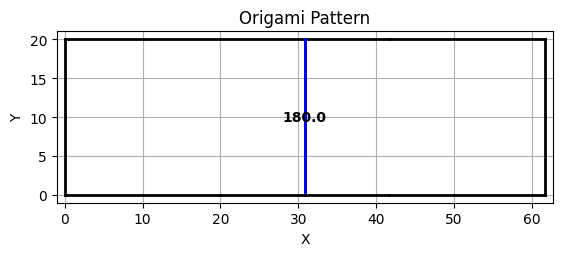

In [24]:
draw_polygons(translate_to_continent(polygons_modified))